## Итоговое задание Анны Лубневской  
### по Проекту 5. Компьютер говорит «Нет» 
###  Юнит 5. Основные алгоритмы машинного обучения. Часть I 

### Описание задачи
- Обработка предоставленных данных: нахождение и заполнение пропусков, кодировка, нормализация признаков;
- Создание новых признаков с использованием предоставленных данных;
- Отбор признаков;
- Визуализация;
- Обучение и тестирование модели на полученных признаках;
- Оптимизация размера набора данных 
- Получение нового значения ROC AUC для новой модели, улучшение ее результатов на основе подбора параметра регуляризации;
- Получение предсказанных моделью значений, подготовка и отправка submission


### Импорт библиотек, установка параметров, определение функций

In [6]:
import pandas as pd
from pandas import Series
import numpy as np
from sklearn.model_selection import train_test_split, cross_validate, learning_curve 
from sklearn.ensemble import RandomForestRegressor 
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
import re
import math
import copy
from IPython.display import display
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from importlib import reload
from tqdm import tqdm
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

import os

In [7]:
# функции используемые в ноутбуке

def df_describe(df):
    desc = df.describe(include='all',percentiles=[0.5]).T
    desc['type'] = [type(x) for x in df.iloc[0]]
    desc['NaN'] = df.isna().sum()
    desc.unique = df.nunique()
    desc.top = df.mode(axis=0).iloc[0]
    desc.freq = [df[col].value_counts().iloc[0] for col in  df.columns]
    return desc

def nums_visualisation(df,annotation=False):
    columns = df.columns
    cols_num = df.shape[1]
    
    fstr = '\033[1m{}\033[0m, '* (len(columns)-1) + '\033[1m{}\033[0m'
    if annotation: print(('Всего признаков этого типа {}. К ним относятся: ' + fstr).format(len(columns),*columns))

    indent = 0.05
    fig = plt.figure(figsize=(14,3))
    for i,col in enumerate(columns):
        row = df[col]
        min_diff = pd.Series(row.unique()).sort_values().diff().min()
        bins = min(int((row.max()-row.min()) /min_diff + 1),100)
        
        fig.add_axes([1/cols_num*i, 0.35, 1/cols_num-indent, 1])
        plt.title(col)
        row.plot.hist(bins=bins,density=True)
    
        fig.add_axes([1/cols_num*i, 0, 1/cols_num-indent, 0.2])
        sns.boxplot(x=row)

    plt.tight_layout()

def num_visualisation(column,df_inp,lg=False): 
    df = df_inp.copy()
    
    if lg: df[column] = np.log(df[column]+1)
        
    hue = df.default
    trn = df[df['sample']==1]
    tst = df[df['sample']==0]
    
    row = df[column]
    row1 = trn[column][hue==0]
    row2 = trn[column][hue==1]
    
    row3 = trn[column]
    row4 = tst[column]
    
    min_diff = pd.Series(row.unique()).sort_values().diff().min()
    bins = min(int((row.max()-row.min()) /min_diff + 1),100)
    bins_range = row.min()-min_diff/2 ,row.max()+min_diff/2 

    fig = plt.figure(figsize=(14,4))
    
    ax1 = fig.add_axes([0, 0.4, 0.45, 1])
    plt.title('Распределение '+column+' в train в зависимоти от значения default' )
    row1.plot.hist(bins=bins,density=True,alpha = 0.65)
    row2.plot.hist(bins=bins,density=True,alpha = 0.65)
    plt.legend(['negative','positive'])
    
    ax2 = fig.add_axes([0, 0, 0.45, 0.30]) 
    ax1.get_shared_x_axes().join(ax1, ax2)
    sns.boxplot(data = [row1,row2],orient='h',saturation = 0.5)
    
    ax3 = fig.add_axes([0.55, 0.4, 0.45, 1])
    plt.title('Распределение '+column+' в train и test' )
    row3.plot.hist(bins=bins,density=True,alpha = 0.65)
    row4.plot.hist(bins=bins,density=True,alpha = 0.65)
    plt.legend(['train','test'])  
    
    ax4 = fig.add_axes([0.55, 0, 0.45, 0.30]) 
    ax4.get_shared_x_axes().join(ax3, ax4)
    sns.boxplot(data = [row3,row4],orient='h',saturation = 0.5)

    
def cats_visualisation(df):
    columns = df.columns
    cols_num = df.shape[1]
    
    fstr = '\033[1m{}\033[0m, '* (len(columns)-1) + '\033[1m{}\033[0m'
    print(('Всего признаков этого типа {}. К ним относятся: ' + fstr).format(len(columns),*columns))
    
    indent = 0.05
    fig = plt.figure(figsize=(14,3))
    for i,col in enumerate(columns):
        row = df[col]
        bins = df.shape[1]
        
        fig.add_axes([1/cols_num*i, 0, 1/cols_num-indent, 1])
        plt.title(col)
        sns.countplot(df[col])
    
def cat_visualisation(row):
    feat_name = row.name
    fig, axes = plt.subplots(1,2,figsize = (14,5))
    
    hue = data.default
    
    dist_1 = pd.DataFrame({'neg':row[hue==0].value_counts(normalize=True),
                           'pos':row[hue==1].value_counts(normalize=True)})
    ind = dist_1.index
    dist_2 = pd.DataFrame({'neg':data.groupby(feat_name).default.value_counts(normalize=True)[:,0],
                           'pos':data.groupby(feat_name).default.value_counts(normalize=True)[:,1]}).loc[ind]
    
    display(dist_2.T)
    dist_1.plot.bar(title = 'Распределение категорий '+ feat_name + '\n при разных значениях default',ax = axes[0])
    dist_2.plot.bar(title = 'Распределение default в каждой категории '+ feat_name,ax = axes[1],stacked=True)
    plt.legend(loc = 4)
    
def pre_process(df_inp):
    df = df_inp.copy()
    label_encoder = LabelEncoder()
    scaler = StandardScaler()    
    
    # заполнение пропусков
    df.education.fillna(df.education.mode()[0],inplace=True)
    
    df.drop(columns='app_date',inplace=True)
    
    # разделение на типы призанков
    num_uniq = df.nunique()
    bin_cols = df.columns[num_uniq==2]
    cat_cols = df.columns[(num_uniq>2) & (num_uniq<10)] 
    num_cols = df.columns[num_uniq>=10]
    
    # обработка численных признаков
    for col in num_cols.drop(['client_id','score_bki']):
        df[col] = np.log(df[col]+1)
        
    df[num_cols] = scaler.fit_transform(df[num_cols].values)
    
    # обработка категориальных признаков
    df = pd.get_dummies(df,columns=cat_cols)
    
    # отбработка бинарных признаков
    for col in bin_cols:
        df[col] = label_encoder.fit_transform(df[col])
    
    # удаление client_id
    df.drop(columns='client_id')
        
    return df

def validation(X,y,model):
    model = model
    cv_results = cross_validate(model, X, y, scoring='roc_auc', cv=5,)
    return cv_results['test_score'].mean()

In [8]:
# установка параметров
%pylab inline

pd.set_option('display.max_rows', 70) # выведем больше строк
pd.set_option('display.max_columns', 30) # выведем больше колонок

RANDOM_SEED = 42
model = LogisticRegression()

solvers_hyperparameters = {
    'newton-cg': {'penalty': ['l2'] , 
#                   'tol': logspace(-5,-3,2) ,
                  'C': logspace(-3, 3, 7) , 
                  'class_weight':  [{0:1, 1:x} for x in range(1,13,3)] ,
                  'max_iter': [500] 
                 }, 
    'lbfgs':     {'penalty': ['l2'] , 
#                   'tol': logspace(-5,-3,2) ,
                  'C': logspace(-3, 3, 7) , 
                 'class_weight':  [{0:1, 1:x} for x in range(1,13,3)] ,
                  'max_iter': [500] 
                 }, 
    'liblinear': {'penalty': ['l1', 'l2'] , 
#                   'tol': logspace(-5,-3,2) ,
                  'C': logspace(-3, 3, 7) , 
                  'intercept_scaling': [1,3,10,33,100],  
                 'class_weight':  [{0:1, 1:x} for x in range(1,13,3)] 
                 },
    'sag':       {'penalty': ['l2'] , 
#                   'tol': logspace(-5,-3,2) ,
                  'C': logspace(-3, 3, 7) , 
                 'class_weight':  [{0:1, 1:x} for x in range(1,13,3)] ,
                  'max_iter': [500] 
                 }, 
    'saga':      {'penalty': ['l1', 'l2'] , 
#                   'tol': logspace(-5,-3,2) ,
                  'C': logspace(-3, 3, 7) , 
                 'class_weight':  [{0:1, 1:x} for x in range(1,13,3)] 
                 }
}

Populating the interactive namespace from numpy and matplotlib


### Знакомство с данными

### Описание датасета
Состоит столбцов, содержащих следующую информацию:

- **client_id** - идентификатор клиента
- **app_date** - дата подачи заявки
- **education** - уровень образования
- **sex** - пол заёмщика
- **age** - возраст заёмщика
- **car** - флаг наличия автомобиля
- **car_type**	- флаг автомобиля-иномарки
- **decline_app_cnt** - количество отказанных прошлых заявок
- **good_work** - флаг наличия «хорошей» работы
- **score_bki** - скоринговый балл по данным из БКИ
- **bki_request_cnt** - количество запросов в БКИ
- **region_rating** - рейтинг региона
- **home_address** - категоризатор домашнего адреса
- **work_address** - категоризатор рабочего адреса
- **income** - доход заёмщика
- **sna** - связь заемщика с клиентами банка
- **first_time** - давность наличия информации о заемщике
- **foreign_passport** - наличие загранпаспорта
- **sample**
- **default** - наличие дефолта (целевая переменная)

In [73]:
sample_submission = pd.read_csv('data/sample_submission.csv')
test = pd.read_csv('data/test.csv')
train = pd.read_csv('data/train.csv')

Для корректной работы с признаками объединим train и test в один датасет data

In [74]:
train['sample'] = 1  # помечаем где у нас train
test['sample'] = 0   # помечаем где у нас test
test['default'] = 0  # в test нет значения default, поэтому пока просто заполняем нулями

data = test.append(train, sort=False).reset_index(drop=True) # объединяем

In [75]:
# Проверим наличие дупликатов
data.duplicated().sum()

0

In [76]:
# посмотрим на данные

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

In [77]:
data.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Columns: 20 entries, client_id to default
dtypes: float64(1), int64(13), object(6)
memory usage: 16.8+ MB


In [78]:
data.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N,0,0
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N,0,0
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y,0,0
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N,0,0
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N,0,0


In [79]:
display(df_describe(data))

,count,unique,top,freq,mean,std,min,50%,max,type,NaN
client_id,110148,110148,1,1,55074.5,31797.1,1,55074.5,110148,<class 'numpy.int64'>,0
app_date,110148,120,18MAR2014,1491,NaN,NaN,NaN,NaN,NaN,<class 'str'>,0
education,109670,5,SCH,57998,NaN,NaN,NaN,NaN,NaN,<class 'str'>,478
sex,110148,2,F,61836,NaN,NaN,NaN,NaN,NaN,<class 'str'>,0
age,110148,52,31,4084,39.2494,11.5181,21,37,72,<class 'numpy.int64'>,0
car,110148,2,N,74290,NaN,NaN,NaN,NaN,NaN,<class 'str'>,0
car_type,110148,2,N,89140,NaN,NaN,NaN,NaN,NaN,<class 'str'>,0
decline_app_cnt,110148,24,0,91471,0.273205,0.799099,0,0,33,<class 'numpy.int64'>,0
good_work,110148,2,0,91917,0.165514,0.371645,0,0,1,<class 'numpy.int64'>,0
score_bki,110148,102618,-1.77526,517,-1.90454,0.499397,-3.62459,-1.92082,0.199773,<class 'numpy.float64'>,0


Как видиим 14 признаков представлены числовым типом данных, 6 строковыми величинами. Из этих 6 "строковых" признаков 4 признака бинарных, один категориальный(5 уникальных значений, одно из них NaN) и один,`app_date`- временной ряд.  

Пропуски встречаются только в одном признаке `education`. Их количество не велико и составляет менее 0,5% от количества наблюдений.  

Сравнивая количество уникальных значений *unique* и частоту  наиболее часто встречающейся категории *freq* можно заметь несбалансированность признаков по категориям. В `foreign_passport` `good_work` `decline_app_cnt` и `default` доля дисбаланса составляет около 6/7, что особенно в целевой переменной `default` может создать проблемы при обучении модели. Нам придется предпринимать меры для устранения несбалансированности.

Посмотрим на данные:

In [80]:
data.sample(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
71635,46651,23FEB2014,SCH,F,43,N,N,1,0,-2.043009,5,80,2,3,55000,1,4,Y,1,0
86935,95304,11APR2014,SCH,F,41,N,N,0,0,-2.104211,1,40,2,3,40000,1,3,N,1,0
93263,102502,20APR2014,SCH,M,61,Y,Y,0,0,-1.999511,4,40,2,3,58000,4,3,N,1,0
96100,27454,03FEB2014,SCH,M,53,N,N,2,0,-0.993058,1,70,1,2,40000,2,3,Y,1,0
78762,62737,12MAR2014,GRD,M,39,Y,Y,0,0,-1.601289,2,50,1,1,60000,2,3,N,1,0


Предлагаю на этом этапе разделить признаки на количественные `num_cols` , категориальные `cat_cols` и бинарные `bin_cols`.
Временной ряд рассмотрим отдельно.

In [81]:
num_uniq = train.nunique()
time_col = pd.Index(['app_date'])
bin_cols = train.columns[num_uniq==2]
cat_cols = train.columns[(num_uniq>2) & (num_uniq<10)] 
num_cols = train.columns[num_uniq>=10].drop(time_col)

### Работа с данными
Сперва рассмотрим существующие признаки, разделив их по типам. Выберем способы предобработки, извлечем, если возможно, из существующих признаков информацию для создания новых. Затем предобработаем существующие признаки согласно выбранным способам. После этого создадим новые, при необходимости предобработаем и их тоже.


### Временной признак

Временной признак у нас в строковом виде. Приведем его к типу `Datetime`. Затем сразу на этой стадии извлечем из него  признаки `app_day_num`, `app_weekday`, `day`, `app_day_weekend`  и `app_month_beginning` - возможно, они понадобятся нам при работе в дальнейшем. После чего удалим исходный `app_date`.

In [82]:
from datetime import datetime

data.app_date = pd.to_datetime(data.app_date,format='%d%b%Y')

data['app_day_num'] = (data.app_date - data.app_date.min()).dt.days  # день подачи заявки от начала ведения БД
data['app_weekday'] = data.app_date.dt.weekday                       # день недели подачи заявки
data['day'] = data.app_date.dt.day                                   # число подачи заявки
data['app_day_weekend'] = data.app_date.dt.weekday.ge(5).astype(int) # день подачи заявки - выходной
data['app_month_beginning'] = data.app_date.dt.day.le(7).astype(int) # подача заявки в первые 7 дней месяца

# data.drop(columns='app_date',inplace=True)

Посмотрим на распределения полученных признаков

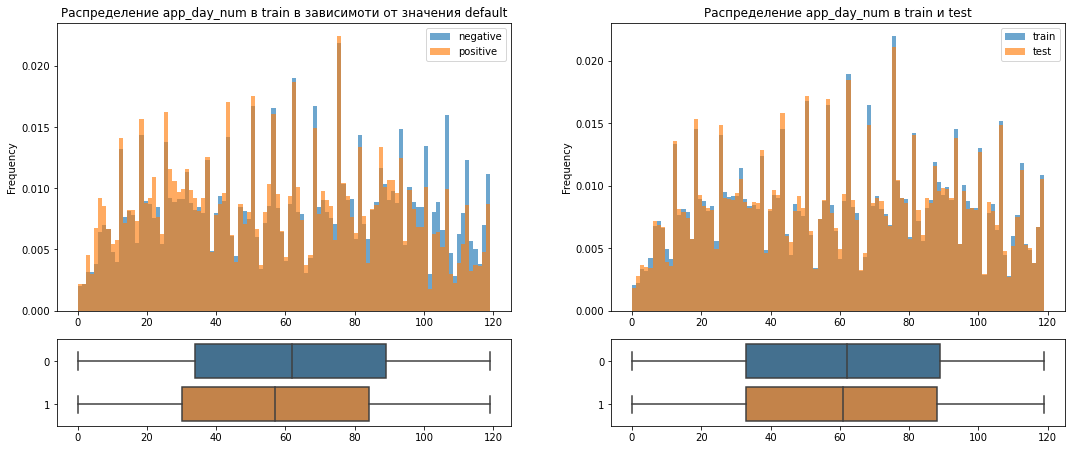

In [83]:
num_visualisation('app_day_num',data)

На графике распределений `app_day_num` в обучающей части выборки заметен сдвиг влево. Со временем доля дефолтов падает. Обьяснения тому могут быть разные: банк настроил систему скоринга или , например, более поздние клиенты еще не успели показать свои возможности.  

На графике распределений `app_day_num` на обучающей и тестовой части выборки заметна маленькая разница - медиана и 3 квартиль на тестовой части немного меньше. Разница небольшая, но есть. Если такая картина повторится во других признаках, то будет смысл провести нормирование выборки.

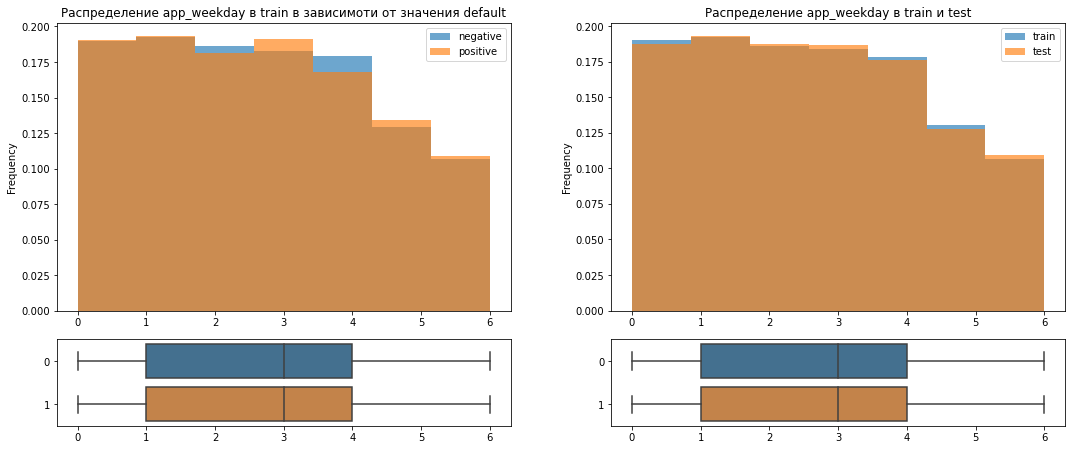

In [84]:
num_visualisation('app_weekday',data)

,0,1,2,3,4,5,6
neg,0.914436,0.914686,0.917013,0.912003,0.919338,0.911654,0.914148
pos,0.085564,0.085314,0.082987,0.087997,0.080662,0.088346,0.085852


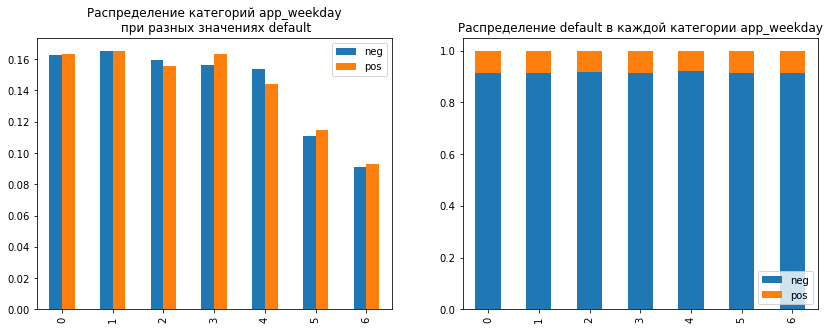

In [85]:
cat_visualisation(data[data['sample']==1].app_weekday)

У дефолтных клиетов четверг и выходные дни чуть более популярны для подачи заявки, чем у платежеспособных.

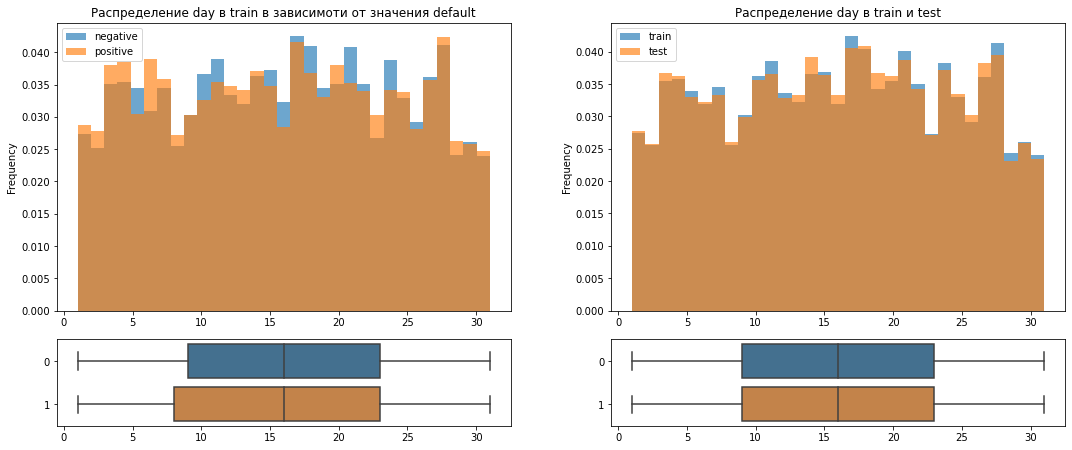

In [86]:
num_visualisation('day',data)

В этом признаке распределние дефолта немного сдвинуто влево. Вероятно, клиенты со склонностью к дефолту подают заявку на кредит в начале месяца, а клиенты платежеспособныые несколько позже. Разницы в распределении признака в обучающей и тестовой части нет (не заметна).

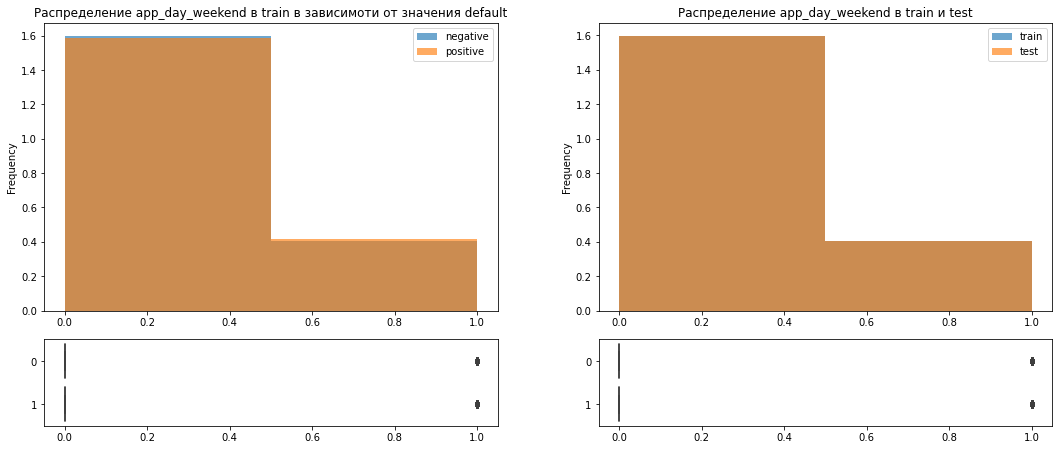

In [87]:
num_visualisation('app_day_weekend',data)

,0,1
neg,0.915456,0.912787
pos,0.084544,0.087213


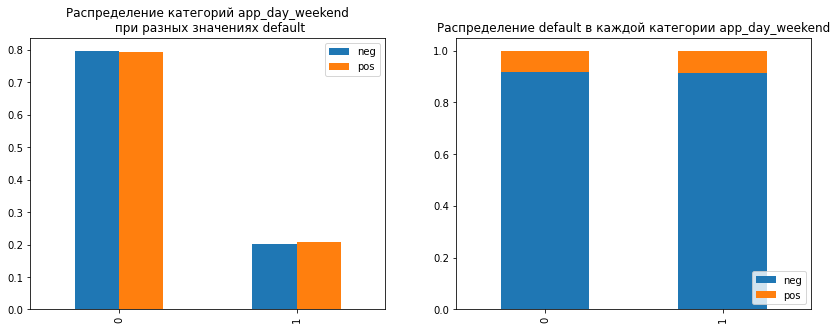

In [88]:
cat_visualisation(data[data['sample']==1].app_day_weekend)

Заметить можно лишь небольшое повышение популярности выходных дней для подачи заявки среди дефолтных клиентов. Возможно, они наемные рабочие, и не имеют возможности обращаться в банк в рабочее вермя будних дней.

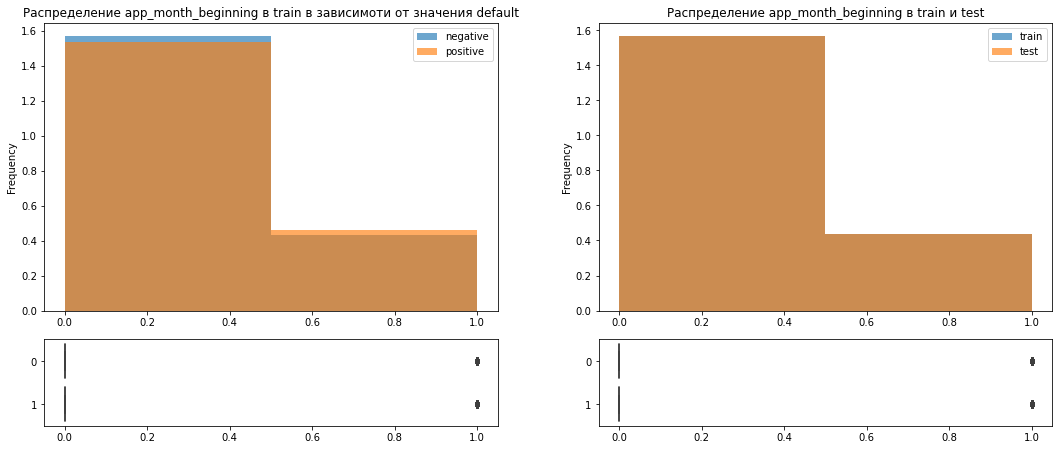

In [89]:
num_visualisation('app_month_beginning',data)

,0,1
neg,0.91635,0.909751
pos,0.08365,0.090249


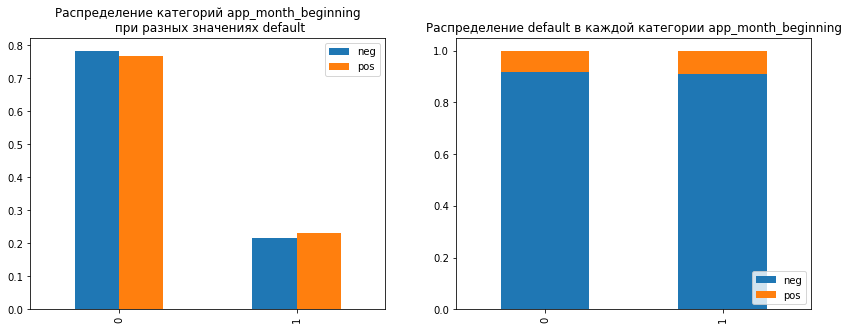

In [90]:
cat_visualisation(data[data['sample']==1].app_month_beginning)

Распределине похоже на предыдущие варинаты. Дефолтные клиенты с небольшой разницей подают заявки в начале месяца. 

In [91]:
# Удостоверимся, что все клиенты обращались в 2014 году
data.app_date.dt.year.value_counts()

2014    110148
Name: app_date, dtype: int64

In [92]:
data.app_date.dt.month.value_counts()

3    31597
2    27097
4    26266
1    25188
Name: app_date, dtype: int64

Кроме того, видим, что клиенты обращались с января по апрель

In [93]:
# Выясняем начало и конец периода нашего датасета - это 1 января и 30 апреля 2014 года
start = data.app_date.min()
end = data.app_date.max()
start,end

(Timestamp('2014-01-01 00:00:00'), Timestamp('2014-04-30 00:00:00'))

### Количественные признаки
Начнем с общего обзора, потом перейдем к каждому признаку в отдельности. 

Всего признаков этого типа 6. К ним относятся: client_id, age, decline_app_cnt, score_bki, bki_request_cnt, income


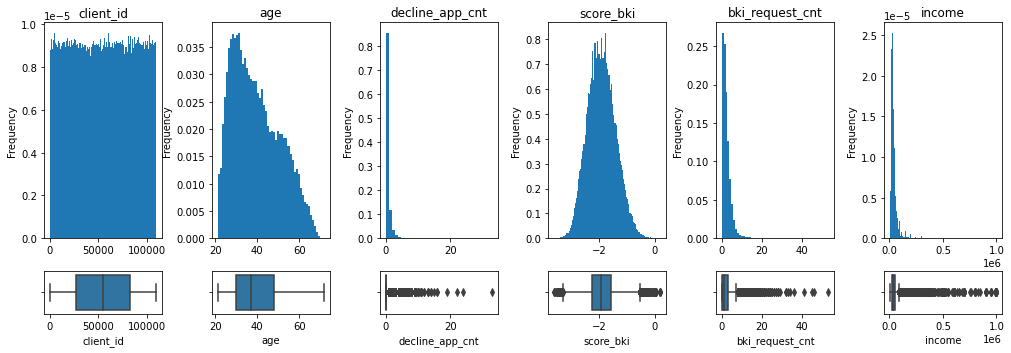

In [94]:
nums_visualisation(train[num_cols], annotation=True)

Кроме client_id и score_bki, признаки не имеютнормального распределения, а склонны к смещению вправо. Применим логарифмирование:

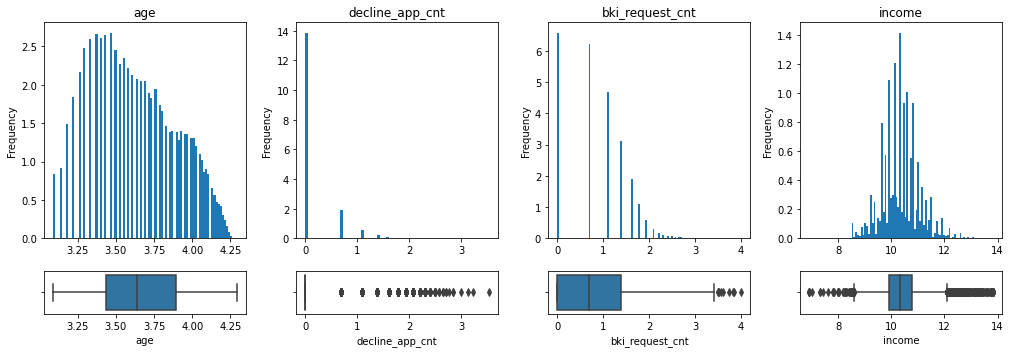

In [95]:
nums_visualisation(np.log(train[num_cols.drop(['client_id','score_bki'])]+1))

### age

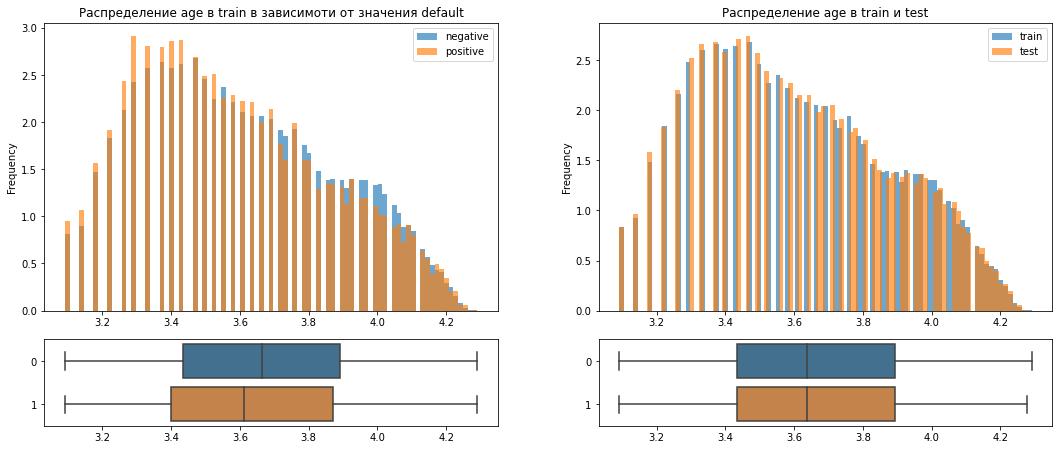

In [96]:
num_visualisation('age',data,lg=True)

Дефолтные клиенты более молодые. Разница в распределении признака в обучающей и тестовой части незаметна

### decline_app_cnt
Количество отказанных прошлых заявок

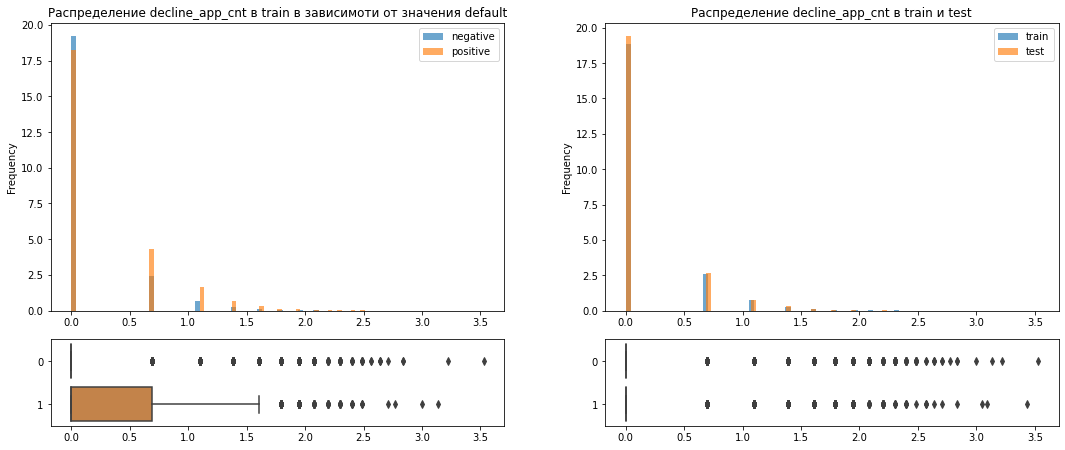

In [97]:
num_visualisation('decline_app_cnt',data,lg=True)

Количество отказов дефолтным клиентам выше, чем платежеспсосбным. 

In [98]:
#добавим признак с логарифмом 
data['decline_app_cnt_log']=np.log(data['decline_app_cnt']+1)

### score_bki
Скоринговый балл по данным из БКИ

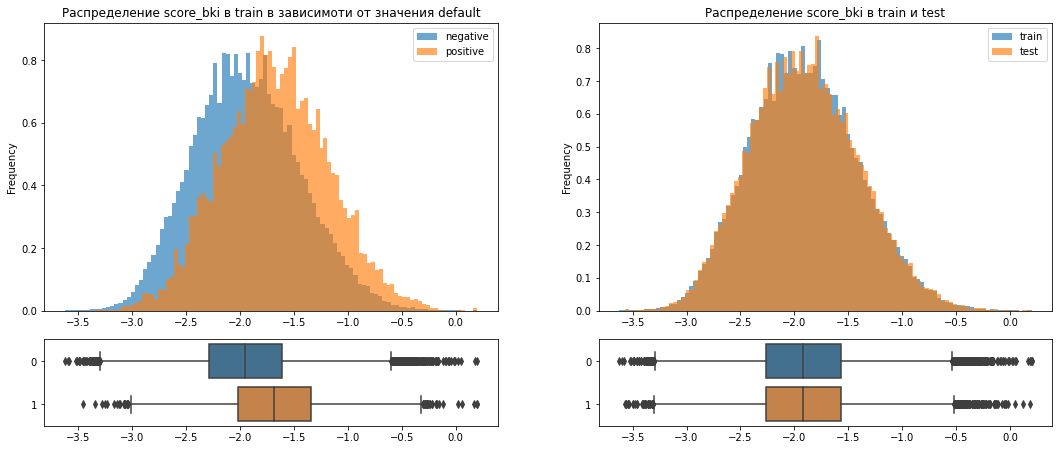

In [99]:
num_visualisation('score_bki',data)

Сильная разница баллов в распределениях дефолтных и платежеспопосбных клиентов. Признак полезный. Различия в распределении в обучающей и тестовой части не видно.

### bki_request_cnt
Количество запросов в БКИ

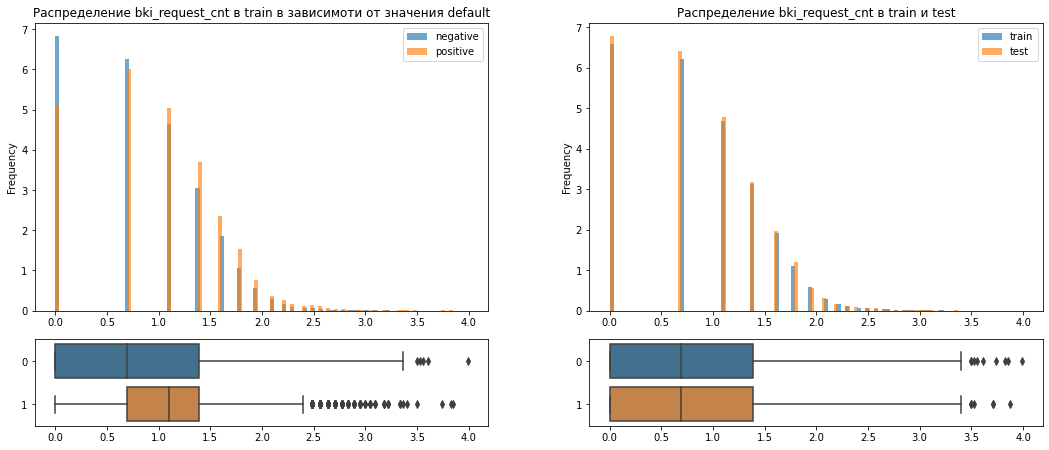

In [100]:
num_visualisation('bki_request_cnt',data,lg=True)

Распределение похоже на распределение Пуассона. У дефолтных среднее количество запросов выше. Возможно, они чаще пытаются получить кредит или рассрочку. Значительная разница в распределениях в обучающей и тестовой части отсутсвует.

In [101]:
#добавим признак с логарифмом 
data['bki_request_cnt_log']=np.log(data['bki_request_cnt']+1)

### income
Доход клиента-заемщика

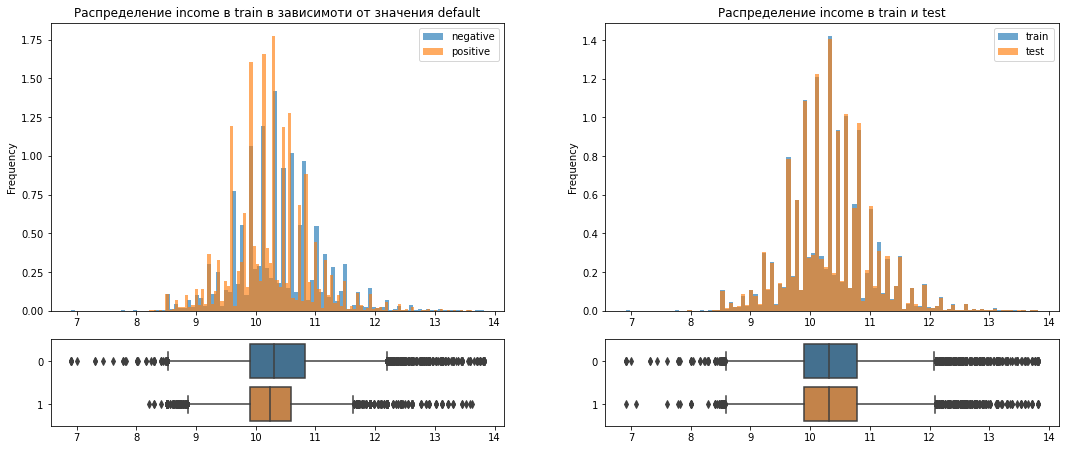

In [102]:
num_visualisation('income',data,lg=True)

Любопытный результат. Доходы дефолтных клиентов ниже, к тому же меньше разброс их доходов. Что самое интересное -наиболее низкие доходы как раз у платежеспособных. Как вариант, они не показывают свои реальные доходы. Или клиентам с минимальными доходами не дают кредит, а это в свою очередь результат отсутствия дефолта.  
Разница между обучающей и тестовой выборкой отсутствует.

In [103]:
#добавим признак с логарифмом 
data['income_log']=np.log(data['income']+1)

In [104]:
data.head(3)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default,app_day_num,app_weekday,day,app_day_weekend,app_month_beginning,decline_app_cnt_log,bki_request_cnt_log,income_log
0,74835,2014-03-22,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N,0,0,80,5,22,1,0,0.000000,1.386294,10.819798
1,17527,2014-01-24,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N,0,0,23,4,24,0,0,1.791759,1.098612,8.517393
2,75683,2014-03-23,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y,0,0,81,6,23,1,0,0.000000,0.693147,10.308986
